In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

sns.set()

In this section, we load the RECS (Residential Energy Consumption Survey) dataset and remove columns associated with the "End-use Model" to avoid using derived features from other models.

In [2]:
recs_codebook_df = pd.read_csv('recs2020_codebook.csv', header=1)
print("Codebook loaded successfully.")

recs_df = pd.read_csv('recs2020_data.csv')
print("Data loaded successfully.")

Codebook loaded successfully.
Data loaded successfully.


In [3]:
recs_codebook_df.head()

,Comment,Include,Variable,Type,Description and Labels,Response Codes,Section
0,UID,y,DOEID,Num,Unique identifier for each respondent,100001-118496,ADMIN
1,should we choose one?,y,REGIONC,Char,Census Region,Midwest\nNortheast\nSouth\nWest,GEOGRAPHY
2,should we choose one?,n,DIVISION,Char,"Census Division, Mountain Division is divided ...",East North Central\nEast South Central\nMiddle...,GEOGRAPHY
3,"These are redundant, let's pick one",n,STATE_FIPS,Char,State Federal Information Processing System Code,state_dictionary!A1,GEOGRAPHY
4,NaN,y,state_postal,Char,State Postal Code,state_dictionary!A1,GEOGRAPHY


In [4]:
# Filter for only single-family homes (attached)
single_family_homes = recs_df[(recs_df['TYPEHUQ'] == 2)]

# Function to convert floats to integers and preserve NaN
def convert_to_int(x):
    if isinstance(x, float):
        if np.isnan(x):
            return np.nan  # Preserve NaN
        else:
            return int(x)  # Convert float to integer
    return x

# Apply the conversion to all numeric values
single_family_homes = single_family_homes.applymap(convert_to_int)

# Now, select columns where 'Include' is 'y' or 'category'
cols_to_keep = recs_codebook_df[(recs_codebook_df['Include'] == 'y') |
                                (recs_codebook_df['Include'] == 'category')]['Variable'].tolist()


# Select columns marked as 'outlier' to handle them separately
cols_to_fix = recs_codebook_df[recs_codebook_df['Include'] == 'outlier']['Variable'].tolist()

# Create a subset of the dataframe with selected columns
df_y = single_family_homes[cols_to_keep]
df_f = single_family_homes[cols_to_fix]

print(f"Selected {len(cols_to_keep)} features for analysis.")
print(f"Selected {len(cols_to_fix)} features to update.")

Selected 56 features for analysis.
Selected 68 features to update.


In [5]:
# def map_codes_to_descriptions(column, response_codes):
#     """ Maps numeric codes to their respective descriptions based on the codebook. """
#     mapping = {}
#     if isinstance(response_codes, str):
#         for item in response_codes.split('\n'):
#             parts = item.split(maxsplit=1)  # split by max of 2 to ensure correct parsing
#             if len(parts) == 2:  # ensure there are exactly 2 elements: code and description
#                 code, desc = parts
#                 try:
#                     # Map both float and integer versions of the code
#                     mapping[float(code)] = desc.strip()
#                     mapping[int(float(code))] = desc.strip()  # Add integer counterpart
#                 except ValueError:
#                     # Skip if the code is non-numeric
#                     mapping[code] = desc.strip()
    
#     return column.replace(mapping)

# # Apply categorical transformations and special case handling
# # Cross-check and transform categorical columns with numeric codes
# for var in df_y.columns:
#     if var in recs_codebook_df['Variable'].values:
#         response_codes = recs_codebook_df[recs_codebook_df['Variable'] == var]['Response Codes'].values[0]
#         df_y.loc[:, var] = map_codes_to_descriptions(df_y[var], response_codes)


In [6]:
# Handle outliers in the 'df_f' dataframe
df_f[['USEHUMID', 'H2OMAIN']] = df_f[['USEHUMID', 'H2OMAIN']].replace(99, 5)
df_f[['USECFAN', 'USEDEHUM']] = df_f[['USECFAN', 'USEDEHUM']].replace(99, 0)
df_f[['EQUIPM', 'EQUIPAUXTYPE']] = df_f[['EQUIPM', 'EQUIPAUXTYPE']].replace(99, 15)
df_f['FUELAUX'] = df_f['FUELAUX'].replace(99, 9)
df_f.replace(-2, 0, inplace=True)

# Combine the cleaned 'outlier' columns with the main dataframe
subset_df = df_y.join(df_f)
subset_df.shape

subset_df.isnull().sum().sort_values(ascending=False)

/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_6023/1837989577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f[['USEHUMID', 'H2OMAIN']] = df_f[['USEHUMID', 'H2OMAIN']].replace(99, 5)
/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_6023/1837989577.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f[['USECFAN', 'USEDEHUM']] = df_f[['USECFAN', 'USEDEHUM']].replace(99, 0)
/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_6023/1837989577.py:4: SettingWithCopyWarning:

MEDICALDEV     114
EVHOMEAMT        8
NUMFIREPLC       0
NUMWWAC          0
NUMDLHPAC        0
              ... 
DEHUMTYPE        0
NUMFLOORFAN      0
NUMCFAN          0
AIRCOND          0
ATTICFIN         0
Length: 124, dtype: int64

In [7]:
# Calculate the number of non-missing values in each column
number_values = subset_df.count()

# Identify columns with more than 25% missing data
threshold = 0.75 * len(subset_df)
cols_to_drop = [col for col in subset_df.columns if subset_df[col].count() < threshold]

# Drop columns with too many missing values
subset_df = subset_df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns due to excessive missing data.")

# Recalculate the number of missing values
missing_percentage = subset_df.isnull().mean() * 100
print(f"Remaining missing data percentage: {missing_percentage.mean():.2f}%")

# Check the number of features with missing data
num_missing_cols = subset_df.columns[subset_df.isnull().any()].tolist()
print(f"There are {len(num_missing_cols)} features with missing data remaining.")


Dropped 0 columns due to excessive missing data.
Remaining missing data percentage: 0.01%
There are 2 features with missing data remaining.


In [8]:
subset_df = subset_df.dropna()
subset_df.head()

,DOEID,REGIONC,state_postal,BA_climate,UATYP10,HDD65,CDD65,HDD30YR_PUB,CDD30YR_PUB,TYPEHUQ,...,LGTOUTNITE,LGTOUTLED,LGTOUTCFL,LGTOUTCAN,SMARTMETER,INTDATAACC,SOLAR,WOODTYPE,OUTLET,EVHOMEAMT
0,100001,WEST,NM,Mixed-Dry,U,3844,1679,4451,1027,2,...,3,1,0,0,0,0,0,0,1,0.0
3,100004,SOUTH,SC,Mixed-Humid,U,2614,1718,3229,1653,2,...,0,0,0,0,1,0,0,0,1,0.0
5,100006,SOUTH,TX,Hot-Humid,U,901,3558,1150,3588,2,...,6,1,0,0,1,0,0,1,1,0.0
6,100007,SOUTH,OK,Mixed-Humid,U,3148,2128,3564,2043,2,...,2,1,0,0,1,0,0,0,1,0.0
10,100011,WEST,CA,Hot-Dry,U,1467,2108,1944,1747,2,...,3,1,0,0,1,0,1,0,1,0.0


In [9]:
numerical_cols = recs_codebook_df[recs_codebook_df['Type'] == 'Num']['Variable'].tolist()
categorical_cols = recs_codebook_df[recs_codebook_df['Type'] == 'Char']['Variable'].tolist()

In [10]:
subset_df[numerical_cols].head()

KeyError: "['TOTROOMS', 'STUDIO', 'NUMFRIG', 'SIZRFRI1', 'TYPERFR1', 'AGERFRI1', 'ICE', 'SIZRFRI2', 'TYPERFR2', 'AGERFRI2', 'LOCRFRI2', 'WINECHILL', 'NUMFREEZ', 'UPRTFRZR', 'SIZFREEZ', 'FREEZER', 'AGEFRZR', 'RANGE', 'COOKTOP', 'OVEN', 'RANGEFUEL', 'RANGEINDT', 'RCOOKUSE', 'ROVENUSE', 'COOKTOPFUEL', 'COOKTOPINDT', 'COOKTOPUSE', 'OVENFUEL', 'OVENUSE', 'MICRO', 'AMTMICRO', 'OUTGRILLFUEL', 'OUTGRILL', 'NUMMEAL', 'USECOFFEE', 'TOAST', 'TOASTOVN', 'CROCKPOT', 'PRSSCOOK', 'RICECOOK', 'BLENDER', 'APPOTHER', 'ELFOOD', 'LPCOOK', 'UGCOOK', 'DISHWASH', 'DWASHUSE', 'DWCYCLE', 'AGEDW', 'CWASHER', 'TOPFRONT', 'WASHLOAD', 'WASHTEMP', 'AGECWASH', 'DRYER', 'DRYRFUEL', 'DRYRUSE', 'AGECDRYER', 'TVCOLOR', 'TVSIZE1', 'TVTYPE1', 'TVUSE1', 'TVONWD1', 'TVONWE1', 'TVSIZE2', 'TVTYPE2', 'TVUSE2', 'TVONWD2', 'TVONWE2', 'TVSIZE3', 'TVTYPE3', 'TVUSE3', 'TVONWD3', 'TVONWE3', 'CABLESAT', 'COMBODVR', 'SEPDVR', 'INTSTREAM', 'PLAYSTA', 'DVD', 'VCR', 'TVAUDIOSYS', 'DESKTOP', 'NUMLAPTOP', 'NUMTABLET', 'ELPERIPH', 'NUMSMPHONE', 'CELLPHONE', 'TELLWORK', 'TELLDAYS', 'TLDESKTOP', 'TLLAPTOP', 'TLTABLET', 'TLMONITOR', 'TLOTHER', 'ONLNEDUC', 'INTERNET', 'INTYPECELL', 'INTYPEBROAD', 'INTYPEOTH', 'SMARTSPK', 'SSLIGHT', 'SSTEMP', 'SSSECURE', 'SSTV', 'SSOTHER', 'DNTHEAT', 'FUELHEAT', 'ELWARM', 'UGWARM', 'LPWARM', 'FOWARM', 'WDWARM', 'ELCOOL', 'HEATCNTL', 'COOLCNTL', 'FUELH2O', 'FUELH2O2', 'ELWATER', 'FOWATER', 'LPWATER', 'SOLWATER', 'WDWATER', 'UGWATER', 'ELPAY', 'NGPAY', 'LPGPAY', 'FOPAY', 'WHYPOWEROUT', 'ELOTHER', 'UGOTH', 'LPOTHER', 'FOOTHER', 'USEEL', 'USENG', 'USELP', 'USEFO', 'USESOLAR', 'USEWOOD', 'ALLELEC', 'HHSEX', 'HHAGE', 'EMPLOYHH', 'EDUCATION', 'SDESCENT', 'HOUSEHOLDER_RACE', 'NHSLDMEM', 'NUMCHILD', 'NUMADULT1', 'NUMADULT2', 'ATHOME', 'MONEYPY', 'SCALEB', 'SCALEG', 'SCALEE', 'PAYHELP', 'NOHEATBROKE', 'NOHEATEL', 'NOHEATNG', 'NOHEATBULK', 'NOHEATDAYS', 'NOHEATHELP', 'COLDMA', 'NOACBROKE', 'NOACEL', 'NOACDAYS', 'NOACHELP', 'HOTMA', 'ENERGYASST', 'ENERGYASST20', 'ENERGYASST19', 'ENERGYASST18', 'ENERGYASST17', 'ENERGYASST16', 'ENERGYASSTOTH', 'SQFTRANGE', 'SQFTINCB', 'SQFTINCA', 'SQFTINCG', 'ZACEQUIPAGE', 'ZADQINSUL', 'ZAGECDRYER', 'ZAGECWASH', 'ZAGEDW', 'ZAGEFRZR', 'ZAGERFRI1', 'ZAGERFRI2', 'ZAIRCOND', 'ZAMTMICRO', 'ZATHOME', 'ZATTCCOOL', 'ZATTCHEAT', 'ZATTIC', 'ZATTICFAN', 'ZATTICFIN', 'ZBACKUP', 'ZBASECOOL', 'ZBASEFIN', 'ZBASEHEAT', 'ZBASEOTH', 'ZBEDROOMS', 'ZBLENDER', 'ZCABLESAT', 'ZCELLAR', 'ZCELLPHONE', 'ZCOLDMA', 'ZCOMBODVR', 'ZCONCRETE', 'ZCOOKTOP', 'ZCOOKTOPFUEL', 'ZCOOKTOPINDT', 'ZCOOKTOPUSE', 'ZCOOLAPT', 'ZCOOLCNTL', 'ZCRAWL', 'ZCROCKPOT', 'ZCWASHER', 'ZDEHUMTYPE', 'ZDESKTOP', 'ZDISHWASH', 'ZDOOR1SUM', 'ZDRAFTY', 'ZDRYER', 'ZDRYRFUEL', 'ZDRYRUSE', 'ZDVD', 'ZDWASHUSE', 'ZDWCYCLE', 'ZEDUCATION', 'ZELPAY', 'ZELPERIPH', 'ZEMPLOYHH', 'ZENERGYASST', 'ZENERGYASST16', 'ZENERGYASST17', 'ZENERGYASST18', 'ZENERGYASST19', 'ZENERGYASST20', 'ZENERGYASSTOTH', 'ZEQUIPAGE', 'ZEQUIPAUXTYPE', 'ZEQUIPM', 'ZFOPAY', 'ZFREEZER', 'ZFUELAUX', 'ZFUELH2O', 'ZFUELH2O2', 'ZFUELHEAT', 'ZFUELPOOL', 'ZFUELTUB', 'ZGARGCOOL', 'ZGARGHEAT', 'ZH2OAPT', 'ZH2OMAIN', 'ZHEATAPT', 'ZHEATCNTL', 'ZHEATHOME', 'ZHHAGE', 'ZHHSEX', 'ZHIGHCEIL', 'ZHOTMA', 'ZHOUSEFAN', 'ZHUMIDTYPE', 'ZICE', 'ZINTERNET', 'ZINTSTREAM', 'ZINTYPEBROAD', 'ZINTYPECELL', 'ZINTYPEOTH', 'ZKOWNRENT', 'ZLGTIN1TO4', 'ZLGTIN4TO8', 'ZLGTINCAN', 'ZLGTINCFL', 'ZLGTINLED', 'ZLGTINMORE8', 'ZLGTOUTANY', 'ZLGTOUTCAN', 'ZLGTOUTCFL', 'ZLGTOUTLED', 'ZLGTOUTNITE', 'ZLOCRFRI2', 'ZLPGPAY', 'ZMICRO', 'ZMONEYPY', 'ZMONPOOL', 'ZMONTUB', 'ZMORETHAN1H2O', 'ZNCOMBATH', 'ZNGPAY', 'ZNHAFBATH', 'ZNHSLDMEM', 'ZNOACBROKE', 'ZNOACDAYS', 'ZNOACEL', 'ZNOACHELP', 'ZNOHEATBROKE', 'ZNOHEATBULK', 'ZNOHEATDAYS', 'ZNOHEATEL', 'ZNOHEATHELP', 'ZNOHEATNG', 'ZNUMADULT1', 'ZNUMADULT2', 'ZNUMCFAN', 'ZNUMCHILD', 'ZNUMDLHP', 'ZNUMDLHPAC', 'ZNUMFIREPLC', 'ZNUMFLOORFAN', 'ZNUMFREEZ', 'ZNUMFRIG', 'ZNUMLAPTOP', 'ZNUMMEAL', 'ZNUMPORTAC', 'ZNUMPORTDEHUM', 'ZNUMPORTEL', 'ZNUMPORTHUM', 'ZNUMSMPHONE', 'ZNUMTABLET', 'ZNUMWWAC', 'ZONLNEDUC', 'ZORIGWIN', 'ZOTHROOMS', 'ZOUTGRILLFUEL', 'ZOUTLET', 'ZOVEN', 'ZOVENFUEL', 'ZOVENUSE', 'ZPAYHELP', 'ZPLAYSTA', 'ZPOOLPUMP', 'ZPOWEROUT', 'ZPRKGPLC1', 'ZPRSSCOOK', 'ZRANGE', 'ZRANGEFUEL', 'ZRANGEINDT', 'ZRCOOKUSE', 'ZRECBATH', 'ZRICECOOK', 'ZROOFTYPE', 'ZROVENUSE', 'ZSCALEB', 'ZSCALEE', 'ZSCALEG', 'ZSDESCENT', 'ZSEPDVR', 'ZSIZEOFGARAGE', 'ZSIZFREEZ', 'ZSIZRFRI1', 'ZSIZRFRI2', 'ZSMARTSPK', 'ZSQFTEST', 'ZSQFTINCA', 'ZSQFTINCB', 'ZSQFTINCG', 'ZSQFTRANGE', 'ZSSLIGHT', 'ZSSOTHER', 'ZSSSECURE', 'ZSSTEMP', 'ZSSTV', 'ZSTORIES', 'ZSWIMPOOL', 'ZTELLDAYS', 'ZTELLWORK', 'ZTEMPGONE', 'ZTEMPGONEAC', 'ZTEMPHOME', 'ZTEMPHOMEAC', 'ZTEMPNITE', 'ZTEMPNITEAC', 'ZTLDESKTOP', 'ZTLLAPTOP', 'ZTLMONITOR', 'ZTLOTHER', 'ZTLTABLET', 'ZTOAST', 'ZTOASTOVN', 'ZTOPFRONT', 'ZTREESHAD', 'ZTVAUDIOSYS', 'ZTVCOLOR', 'ZTVONWD1', 'ZTVONWD2', 'ZTVONWD3', 'ZTVONWE1', 'ZTVONWE2', 'ZTVONWE3', 'ZTVSIZE1', 'ZTVSIZE2', 'ZTVSIZE3', 'ZTVTYPE1', 'ZTVTYPE2', 'ZTVTYPE3', 'ZTVUSE1', 'ZTVUSE2', 'ZTVUSE3', 'ZTYPEGLASS', 'ZTYPERFR1', 'ZTYPERFR2', 'ZTYPETHERM', 'ZUGASHERE', 'ZUPRTFRZR', 'ZUSECFAN', 'ZUSECOFFEE', 'ZUSEDEHUM', 'ZUSEEQUIPAUX', 'ZUSEHUMID', 'ZVCR', 'ZWALLTYPE', 'ZWASHLOAD', 'ZWASHTEMP', 'ZWHEATAGE', 'ZWHEATBKT', 'ZWHEATSIZ', 'ZWHYPOWEROUT', 'ZWINDOWS', 'ZWINECHILL', 'ZWINFRAME', 'ZYEARMADERANGE', 'ZTOTROOMS', 'ZDNTHEAT', 'ZTYPEHUQ', 'ZSTUDIO', 'ZOUTGRILL', 'ZHOUSEHOLDER_RACE', 'ZACEQUIPM_PUB', 'ZACEQUIPAUXTYPE_PUB', 'NWEIGHT', 'NWEIGHT1', 'NWEIGHT2', 'NWEIGHT3', 'NWEIGHT4', 'NWEIGHT5', 'NWEIGHT6', 'NWEIGHT7', 'NWEIGHT8', 'NWEIGHT9', 'NWEIGHT10', 'NWEIGHT11', 'NWEIGHT12', 'NWEIGHT13', 'NWEIGHT14', 'NWEIGHT15', 'NWEIGHT16', 'NWEIGHT17', 'NWEIGHT18', 'NWEIGHT19', 'NWEIGHT20', 'NWEIGHT21', 'NWEIGHT22', 'NWEIGHT23', 'NWEIGHT24', 'NWEIGHT25', 'NWEIGHT26', 'NWEIGHT27', 'NWEIGHT28', 'NWEIGHT29', 'NWEIGHT30', 'NWEIGHT31', 'NWEIGHT32', 'NWEIGHT33', 'NWEIGHT34', 'NWEIGHT35', 'NWEIGHT36', 'NWEIGHT37', 'NWEIGHT38', 'NWEIGHT39', 'NWEIGHT40', 'NWEIGHT41', 'NWEIGHT42', 'NWEIGHT43', 'NWEIGHT44', 'NWEIGHT45', 'NWEIGHT46', 'NWEIGHT47', 'NWEIGHT48', 'NWEIGHT49', 'NWEIGHT50', 'NWEIGHT51', 'NWEIGHT52', 'NWEIGHT53', 'NWEIGHT54', 'NWEIGHT55', 'NWEIGHT56', 'NWEIGHT57', 'NWEIGHT58', 'NWEIGHT59', 'NWEIGHT60', 'DOLLAREL', 'ELXBTU', 'PERIODEL', 'ZELAMOUNT', 'KWHSPH', 'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHRFG1', 'KWHRFG2', 'KWHFRZ', 'KWHCOK', 'KWHMICRO', 'KWHCW', 'KWHCDR', 'KWHDWH', 'KWHLGT', 'KWHTVREL', 'KWHTV1', 'KWHTV2', 'KWHTV3', 'KWHAHUHEAT', 'KWHAHUCOL', 'KWHCFAN', 'KWHDHUM', 'KWHHUM', 'KWHPLPMP', 'KWHHTBPMP', 'KWHHTBHEAT', 'KWHEVCHRG', 'KWHNEC', 'KWHOTH', 'BTUELSPH', 'BTUELCOL', 'BTUELWTH', 'BTUELRFG', 'BTUELRFG1', 'BTUELRFG2', 'BTUELFRZ', 'BTUELCOK', 'BTUELMICRO', 'BTUELCW', 'BTUELCDR', 'BTUELDWH', 'BTUELLGT', 'BTUELTVREL', 'BTUELTV1', 'BTUELTV2', 'BTUELTV3', 'BTUELAHUHEAT', 'BTUELAHUCOL', 'BTUELCFAN', 'BTUELDHUM', 'BTUELHUM', 'BTUELPLPMP', 'BTUELHTBPMP', 'BTUELHTBHEAT', 'BTUELEVCHRG', 'BTUELNEC', 'BTUELOTH', 'DOLELSPH', 'DOLELCOL', 'DOLELWTH', 'DOLELRFG', 'DOLELRFG1', 'DOLELRFG2', 'DOLELFRZ', 'DOLELCOK', 'DOLELMICRO', 'DOLELCW', 'DOLELCDR', 'DOLELDWH', 'DOLELLGT', 'DOLELTVREL', 'DOLELTV1', 'DOLELTV2', 'DOLELTV3', 'DOLELAHUHEAT', 'DOLELAHUCOL', 'DOLELCFAN', 'DOLELDHUM', 'DOLELHUM', 'DOLELPLPMP', 'DOLELHTBPMP', 'DOLELHTBHEAT', 'DOLELEVCHRG', 'DOLELNEC', 'DOLELOTH', 'CUFEETNG', 'BTUNG', 'DOLLARNG', 'NGXBTU', 'PERIODNG', 'ZNGAMOUNT', 'BTUNGSPH', 'BTUNGWTH', 'BTUNGCOK', 'BTUNGCDR', 'BTUNGPLHEAT', 'BTUNGHTBHEAT', 'BTUNGNEC', 'BTUNGOTH', 'CUFEETNGSPH', 'CUFEETNGWTH', 'CUFEETNGCOK', 'CUFEETNGCDR', 'CUFEETNGPLHEAT', 'CUFEETNGHTBHEAT', 'CUFEETNGNEC', 'CUFEETNGOTH', 'DOLNGSPH', 'DOLNGWTH', 'DOLNGCOK', 'DOLNGCDR', 'DOLNGPLHEAT', 'DOLNGHTBHEAT', 'DOLNGNEC', 'DOLNGOTH', 'GALLONLP', 'BTULP', 'DOLLARLP', 'LPXBTU', 'PERIODLP', 'ZLPAMOUNT', 'BTULPSPH', 'BTULPWTH', 'BTULPCOK', 'BTULPCDR', 'BTULPNEC', 'BTULPOTH', 'GALLONLPSPH', 'GALLONLPWTH', 'GALLONLPCOK', 'GALLONLPCDR', 'GALLONLPNEC', 'GALLONLPOTH', 'DOLLPSPH', 'DOLLPWTH', 'DOLLPCOK', 'DOLLPCDR', 'DOLLPNEC', 'DOLLPOTH', 'GALLONFO', 'BTUFO', 'DOLLARFO', 'FOXBTU', 'PERIODFO', 'ZFOAMOUNT', 'BTUFOSPH', 'BTUFOWTH', 'BTUFONEC', 'BTUFOOTH', 'GALLONFOSPH', 'GALLONFOWTH', 'GALLONFONEC', 'GALLONFOOTH', 'DOLFOSPH', 'DOLFOWTH', 'DOLFONEC', 'DOLFOOTH', 'BTUWD', 'ZWDAMOUNT', 'TOTALBTUSPH', 'TOTALDOLSPH', 'TOTALBTUWTH', 'TOTALDOLWTH', 'TOTALBTUOTH', 'TOTALDOLOTH', 'TOTALBTU', 'TOTALDOL', 'EVCHRGHOME', 'EVCHRGAPT', 'EVCHRGWKS', 'EVCHRGBUS', 'EVCHRGMUNI', 'EVCHRGDLR', 'EVCHRGHWY', 'EVCHRGOTH', 'EVCHRGTYPE'] not in index"

In [ ]:
raise Exception

In [71]:
# Perform PCA to capture 90% of the variance
pca = PCA(n_components=0.90, random_state=42)
pca_result = pca.fit_transform(subset_df)

print(f"PCA reduced the dataset to {pca_result.shape[1]} principal components.")


PCA reduced the dataset to 63 principal components.


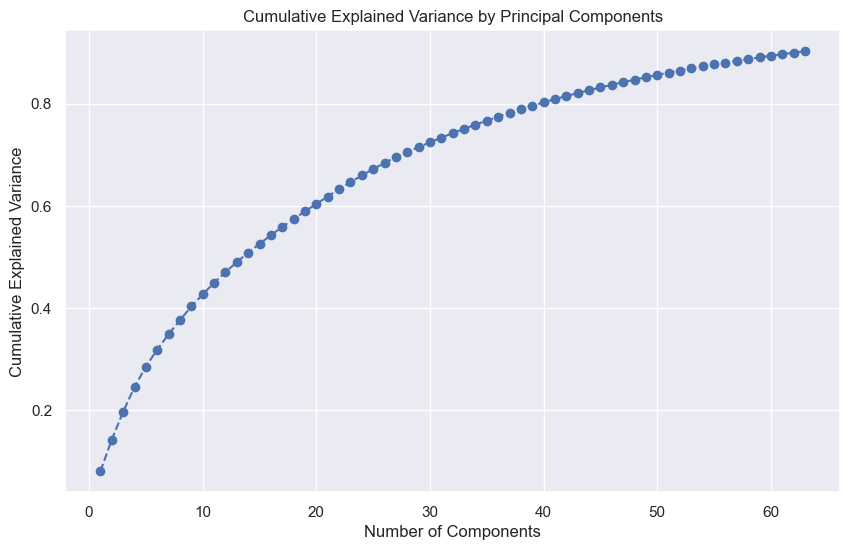

Number of components explaining at least 90% variance: 63


In [72]:
# Plot cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine the number of components that explain at least 90% of the variance
components_90_variance = np.argmax(explained_variance >= 0.90) + 1
print(f"Number of components explaining at least 90% variance: {components_90_variance}")

pca_90 = PCA(n_components=components_90_variance)
pca_90_result = pca_90.fit_transform(subset_df)

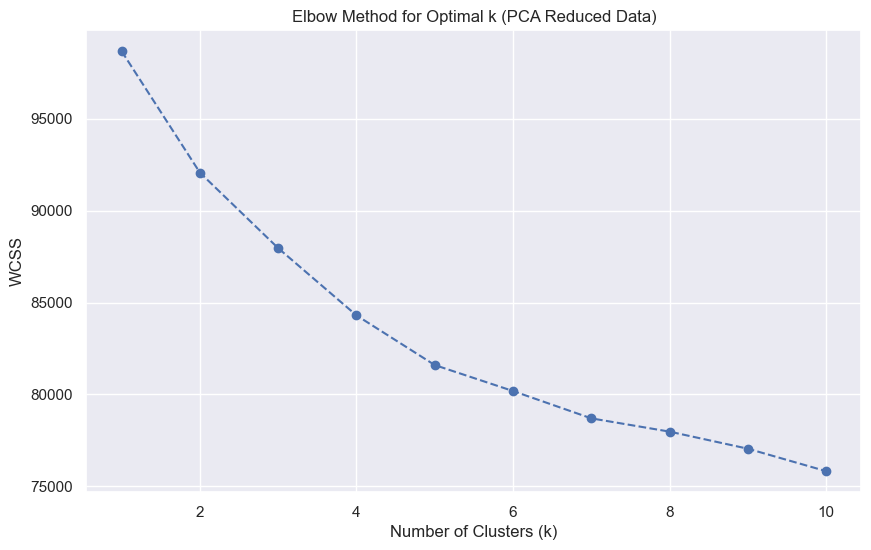

In [73]:
# Calculate WCSS (within-cluster sum of squares) for different values of k
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_90_result)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (PCA Reduced Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [74]:
# Perform K-means clustering with the chosen k
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_90_result)

# Reduce to 2 components for visualization
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=50)
plt.title('K-Means Clustering Results (PCA Reduced to 2 Components)')
plt.show()

KeyboardInterrupt: 

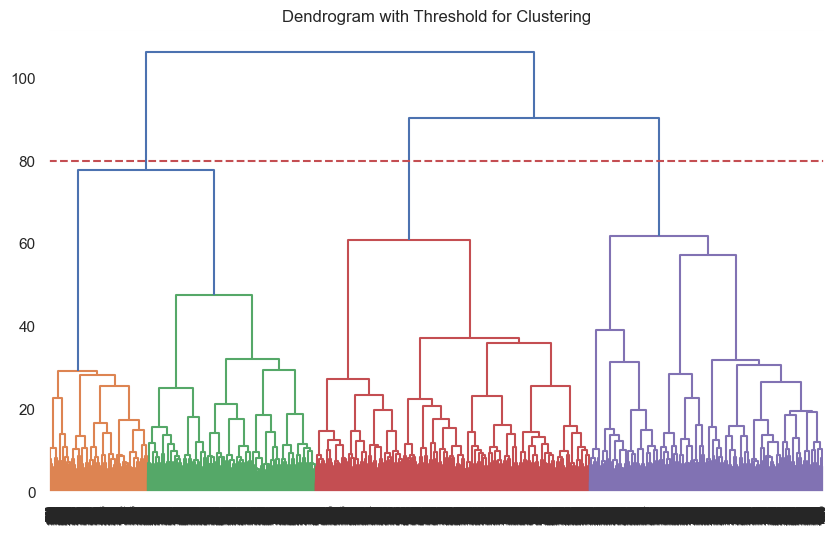

In [47]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# Plot the Dendrogram with a threshold
plt.figure(figsize=(10, 6))
plt.title("Dendrogram with Threshold for Clustering")
dend = shc.dendrogram(shc.linkage(pca_90_result, method='ward'))
plt.axhline(y=80, color='r', linestyle='--')  # Adjust the y-value to focus on higher levels of clustering
plt.show()

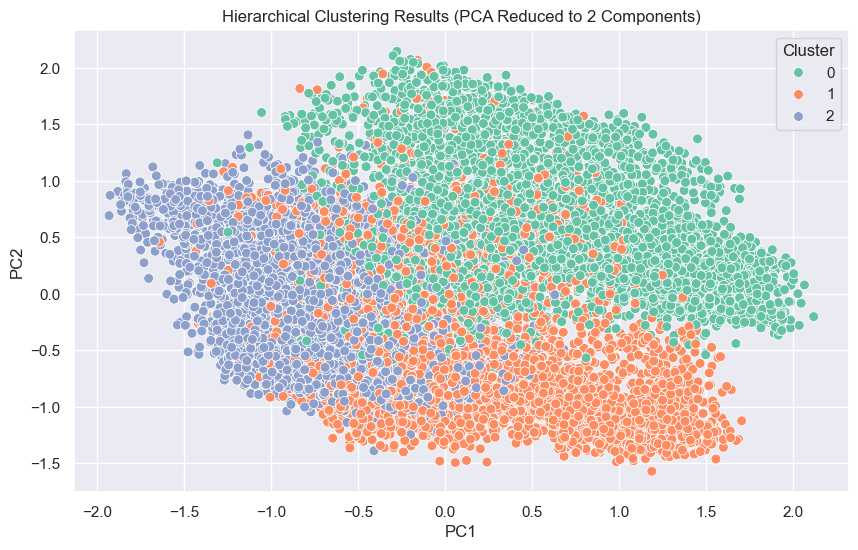

In [48]:
# Perform Hierarchical Clustering with chosen clusters
hierarchical = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(pca_90_result)  

# Visualize the clusters using the first two PCA components
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = hierarchical_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=50)
plt.title('Hierarchical Clustering Results (PCA Reduced to 2 Components)')
plt.show()

We begin by generating summary statistics for each cluster. This will give us an understanding of the average values, medians, and ranges of key features for each cluster.

In [49]:
# Generate summary statistics for each cluster (numerical columns only)
def get_cluster_summary(data, cluster_labels):
    data['Cluster'] = cluster_labels
    # Select only numerical columns
    numeric_data = data.select_dtypes(include=[np.number])
    summary = numeric_data.groupby('Cluster').agg(['mean', 'median', 'min', 'max'])
    return summary

# Apply to K-means clusters
kmeans_summary = get_cluster_summary(subset_df.copy(), kmeans_labels)
print(kmeans_summary)

# Apply to hierarchical clusters
hierarchical_summary = get_cluster_summary(subset_df.copy(), hierarchical_labels)
print(hierarchical_summary)

            DOEID                                   HDD65                 \
             mean    median       min       max      mean    median  min   
Cluster                                                                    
0        0.501218  0.500946  0.000703  0.999838  0.338318  0.328367  0.0   
1        0.504586  0.508813  0.000000  1.000000  0.144537  0.132687  0.0   

                      CDD65            ... LGTINLED       LGTINCFL         \
              max      mean    median  ...      min  max      mean median   
Cluster                                ...                                  
0        1.000000  0.157497  0.159198  ...      0.0  1.0  0.771770   0.75   
1        0.843238  0.407847  0.346043  ...      0.0  1.0  0.760141   0.75   

                   LGTINCAN                   
         min  max      mean median  min  max  
Cluster                                       
0        0.0  1.0  0.753158   0.75  0.0  1.0  
1        0.0  1.0  0.759700   0.75  0.0  1.0 

In [50]:
# Frequency analysis for categorical columns
def get_categorical_frequency(data, cluster_labels):
    # Add the 'Cluster' column to the full dataframe
    data['Cluster'] = cluster_labels
    
    # Include 'Cluster' in the dataset explicitly
    categorical_data = data.select_dtypes(include=['object', 'category', 'bool']).copy()
    
    # Add back the 'Cluster' column since it might get excluded from filtering
    categorical_data['Cluster'] = data['Cluster']
    
    # Calculate the frequency
    frequency = categorical_data.groupby('Cluster').apply(lambda x: x.apply(pd.Series.value_counts))
    
    return frequency

# Apply to K-means clusters
# kmeans_categorical_frequency = get_categorical_frequency(subset_df.copy(), kmeans_labels)
# print(kmeans_categorical_frequency)

# Apply to hierarchical clusters
hierarchical_categorical_frequency = get_categorical_frequency(subset_df.copy(), hierarchical_labels)
print('\n\n\n', hierarchical_categorical_frequency)





                REGIONC_NORTHEAST  REGIONC_SOUTH  REGIONC_WEST  \
Cluster                                                         
0       False             4234.0          288.0        4242.0   
        True                11.0         3957.0           3.0   
1       False             3625.0         3440.0         832.0   
        True                92.0          277.0        2885.0   
2       False             2233.0         4308.0        4179.0   
        True              2124.0           49.0         178.0   
        2                    NaN            NaN           NaN   

               state_postal_AL  state_postal_AR  state_postal_AZ  \
Cluster                                                            
0       False           4082.0           4064.0           4245.0   
        True             163.0            181.0              NaN   
1       False           3714.0           3691.0           3367.0   
        True               3.0             26.0            350.0   
2 

In [51]:
from sklearn.ensemble import RandomForestClassifier
importances = []

# Fit a RandomForest to the clustered data to understand feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(subset_df, kmeans_labels)

# Get feature importance
importances = rf.feature_importances_

# Match importance to feature names
feature_importance_df = pd.DataFrame({'Feature': subset_df.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Top Features Driving Cluster Separation:\n", feature_importance_df.head(10))


Top Features Driving Cluster Separation:
           Feature  Importance
44         CELLAR    0.144806
1           HDD65    0.112118
42            GWT    0.095570
3     HDD30YR_PUB    0.084544
40          DBT99    0.068533
2           CDD65    0.054486
74  REGIONC_SOUTH    0.040955
4     CDD30YR_PUB    0.039908
68        H2OMAIN    0.039062
39           DBT1    0.032489


In [52]:
from scipy.stats import zscore

# Calculate Z-scores for each cluster for numerical columns
def cluster_profiling(data, cluster_labels):
    data['Cluster'] = cluster_labels
    numeric_data = data.select_dtypes(include=[np.number])

    # Group by cluster and calculate z-scores to identify the most distinct features
    z_scores = numeric_data.groupby('Cluster').apply(lambda x: zscore(x, nan_policy='omit'))

    # Ensure 'Cluster' is not both in the index and columns
    z_scores.reset_index(drop=True, inplace=True)

    # Calculate the means and Z-scores of features across clusters
    cluster_means = numeric_data.groupby('Cluster').mean()
    
    # Identify the most distinctive features for each cluster
    distinctive_features = z_scores.abs().groupby(data['Cluster']).mean()

    # Sort by the most distinctive feature by mean Z-score for each cluster
    distinctive_features_sorted = distinctive_features.mean(axis=1).sort_values(ascending=False)
    
    return cluster_means, distinctive_features_sorted

# Apply to K-means clusters
kmeans_means, kmeans_distinctive_features = cluster_profiling(subset_df.copy(), kmeans_labels)

print("K-Means Cluster Means:\n", kmeans_means)
print("\nMost Distinctive Features in Each K-Means Cluster:\n", kmeans_distinctive_features)


K-Means Cluster Means:
             DOEID     HDD65     CDD65  HDD30YR_PUB  CDD30YR_PUB  \
Cluster                                                           
0        0.501218  0.338318  0.157497     0.392212     0.149129   
1        0.504586  0.144537  0.407847     0.180302     0.400016   

         YEARMADERANGE  BEDROOMS  NCOMBATH  NHAFBATH  OTHROOMS  ...  TEMPGONE  \
Cluster                                                         ...             
0             0.354546  0.554720  0.481238  0.243345   0.41025  ...  0.418139   
1             0.507606  0.542504  0.512434  0.176543   0.36250  ...  0.449334   

         TEMPNITE  TEMPHOMEAC  TEMPGONEAC  TEMPNITEAC   H2OMAIN  WHEATBKT  \
Cluster                                                                     
0        0.426184    0.543177    0.574355    0.524552  0.319759  0.172615   
1        0.462284    0.577354    0.615271    0.554805  0.444366  0.201515   

         LGTINLED  LGTINCFL  LGTINCAN  
Cluster                          

In [53]:
# Create a contingency table for each categorical variable
def contingency_tables(data, cluster_labels):
    data['Cluster'] = cluster_labels
    categorical_data = data.select_dtypes(include=['object', 'category', 'bool'])
    
    tables = {}
    for col in categorical_data.columns:
        table = pd.crosstab(data[col], data['Cluster'], normalize='columns')  # Proportions within clusters
        tables[col] = table
    
    return tables

# Get contingency tables for K-means clusters
contingency_tables_kmeans = contingency_tables(subset_df.copy(), kmeans_labels)

contingency_tables_kmeans

{'REGIONC_NORTHEAST': Cluster                  0        1
 REGIONC_NORTHEAST                  
 False              0.67168  0.99224
 True               0.32832  0.00776,
 'REGIONC_SOUTH': Cluster               0         1
 REGIONC_SOUTH                    
 False          0.895623  0.367019
 True           0.104377  0.632981,
 'REGIONC_WEST': Cluster              0         1
 REGIONC_WEST                    
 False         0.813355  0.678131
 True          0.186645  0.321869,
 'state_postal_AL': Cluster                 0         1
 state_postal_AL                    
 False            0.997293  0.973721
 True             0.002707  0.026279,
 'state_postal_AR': Cluster                 0         1
 state_postal_AR                    
 False            0.997744  0.966138
 True             0.002256  0.033862,
 'state_postal_AZ': Cluster                 0         1
 state_postal_AZ                    
 False            0.997443  0.940917
 True             0.002557  0.059083,
 'state_postal_

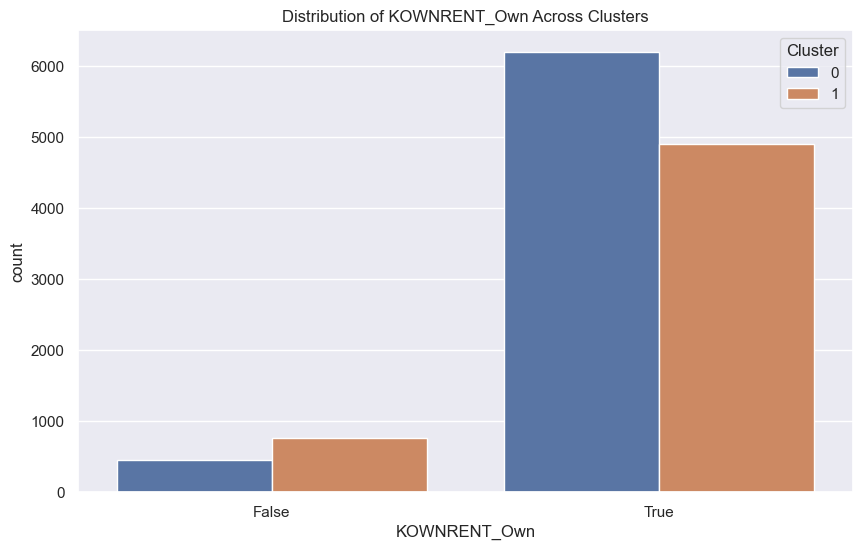

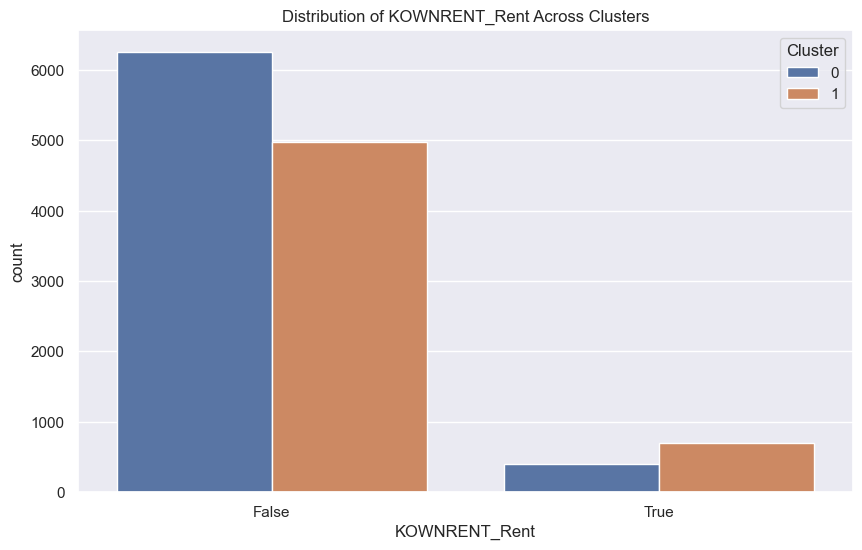

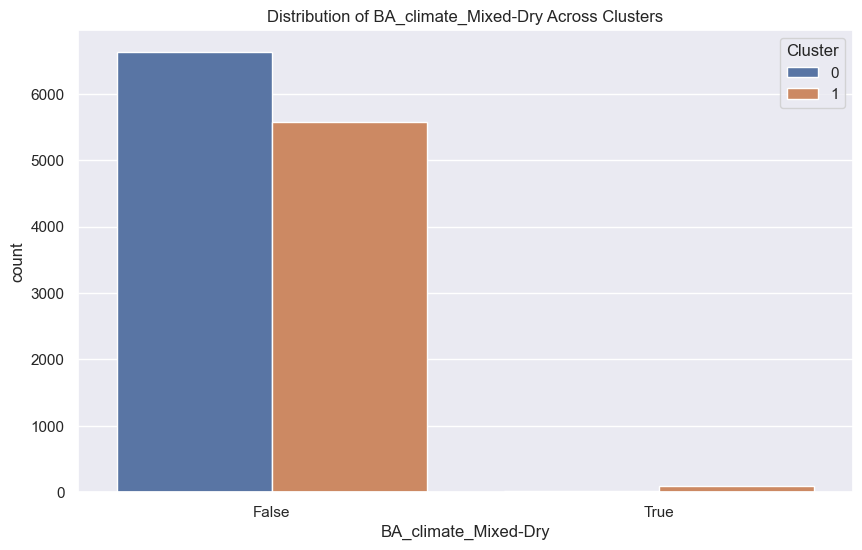

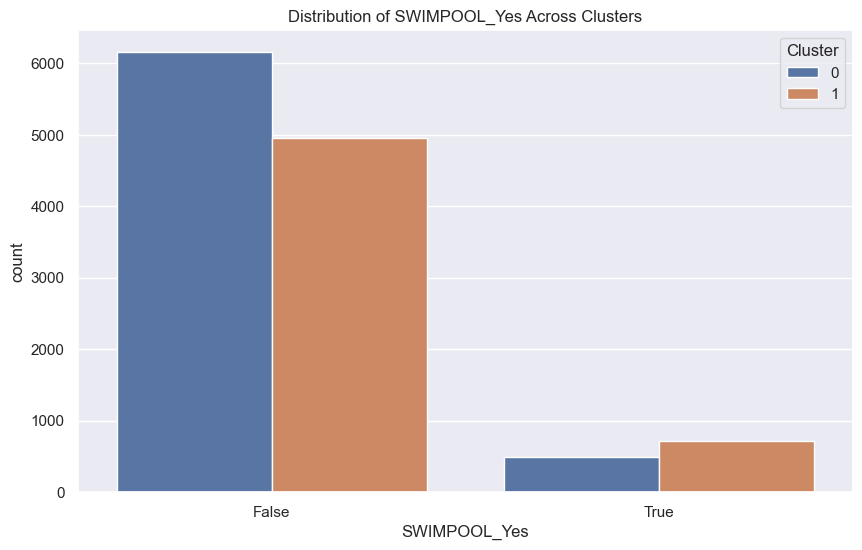

In [57]:
# Visualize the distribution of categorical variables across clusters
def plot_categorical_distributions(data, cluster_labels, categorical_cols):
    data['Cluster'] = cluster_labels
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='Cluster', data=data)
        plt.title(f'Distribution of {col} Across Clusters')
        plt.show()

# List of categorical columns to plot
categorical_cols = ['KOWNRENT_Own', 'KOWNRENT_Rent', 'BA_climate_Mixed-Dry', 'SWIMPOOL_Yes']

# Plot distributions for K-means clusters
plot_categorical_distributions(subset_df.copy(), kmeans_labels, categorical_cols)

In [58]:
# Get the mode of each categorical variable in each cluster
def get_modes_per_cluster(data, cluster_labels):
    data['Cluster'] = cluster_labels
    categorical_data = data.select_dtypes(include=['object', 'category', 'bool'])
    modes = categorical_data.groupby('Cluster').agg(lambda x: x.mode()[0])
    return modes

# Get the mode for K-means clusters
modes_kmeans = get_modes_per_cluster(subset_df.copy(), kmeans_labels)
print("Mode of Categorical Variables per K-Means Cluster:\n", modes_kmeans)

KeyError: 'Cluster'